## Project Tasks
- DONE Divide into test and training data 
- DONE Keep at least 1 subject out of test and training data as a probe 
- DONE Perform feature extraction for each recording.
- DONE Train GMM
- Perform classification using the test samples. Record all scores in a confusion matrix
- Perform validation by submitting the probe sample (of a speaker who is not on the database) and matching it against the trained models. Record the scores.
- Evaluate the error rates using the confusion matrix

In [1]:
#pip install python_speech_features==0.4

In [2]:
# data from 
# https://www.kaggle.com/datasets/alanchn31/free-spoken-digits

# check this out
# https://www.kaggle.com/code/ilyamich/mfcc-implementation-and-tutorial

In [3]:
# Packages 
import os
import re
import random
import numpy as np
from python_speech_features import mfcc
from sklearn.mixture import GaussianMixture
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy.stats import norm

In [4]:
# train the GMM on the concatenated MFCC features
random.seed(0)

person_num = 3  # Index number of person to train on 
test_samples = 10  # Number of samples to test

paths = os.listdir('../data/recordings/')  # Filename of every recording 
random.shuffle(paths) # Shuffle data so test and train contain multiple different words  

# extracts all the people names in the dataset
people = list(set([" ".join(re.findall("[a-zA-Z]+", "".join(x.split('.')[0:-1]))) for x in paths]))
people.sort()

# add relative path
paths = ['../data/recordings/'+ x for x in paths]

print(f'Training on {people[person_num]}')
print(people)

Training on nicolas
['george', 'jackson', 'lucas', 'nicolas', 'theo', 'yweweler']


In [5]:
# Testing with alternative larger and more interesting dataset

# directory containing the training data files
one_person_paths = [x for x in paths if people[person_num] in x]
train_paths = one_person_paths[0:-test_samples]  # Keep the first 490 samples for training
test_paths = one_person_paths[-test_samples:]  # Keep the last 10 samples for testing 

print(len(train_paths))
print(len(test_paths))
#print(test_paths)

490
10


In [6]:
# create a GMM with n components
n = 500
gmm = GaussianMixture(n_components=n)

# loop over each audio file in the data directory to extract features
mfcc_features = None  # Create empty dataframe
for file_path in train_paths:
    sample_rate, audio_data = wavfile.read(file_path)  # extract data and sample rate for each file
    
    # compute MFCC features for the audio data
    mfcc_data = mfcc(audio_data, sample_rate)
    
    # concatenate the MFCC features into a single numpy array
    if mfcc_features is None:
        mfcc_features = mfcc_data
    else:
        mfcc_features = np.concatenate((mfcc_features, mfcc_data), axis=0)

In [7]:
print(mfcc_features[0])

[ 18.28724711   0.10534504 -20.11034637 -46.68443102  -5.85794963
   3.57784646  -6.55325388 -15.80200711 -14.58062069  -3.6266417
  -8.03280999 -12.3525111    4.68319853]


In [8]:
# train the GMM on the concatenated MFCC features
gmm.fit(mfcc_features)

GaussianMixture(n_components=500)

## Jessica's Edits (Your original stuff is at the bottom) 

In [9]:
# Calculate scores for Imposter recordings

imposter_scores = []

for person in people:
    if person != people[person_num]:  # If person was not trained on get a random sample of 10 recordings for testing  
        person_paths = random.sample([x for x in paths if person in x], test_samples)
    else: 
        continue
        
    individual_scores = [] 
    for path in person_paths:
        sample_rate, test_data = wavfile.read(path)  # Extract data
        mfcc_data = mfcc(test_data, sample_rate, numcep=13)  # Feature extraction
        score = gmm.score(mfcc_data) # Calulate score
        individual_scores.append(score)   # Get classification score for each recording
    
    imposter_scores.extend(individual_scores) 

print(len(imposter_scores))

50


In [10]:
# Calculate scores for genuine recordings 

genuine_scores = []

for path in test_paths:
    sample_rate, test_data = wavfile.read(path)  # Extract data
    mfcc_data = mfcc(test_data, sample_rate, numcep=13)  # Feature extraction
    score = gmm.score(mfcc_data) # Calulate score
    genuine_scores.append(score)   # Get classification score for each recording
    
print(len(genuine_scores))

10


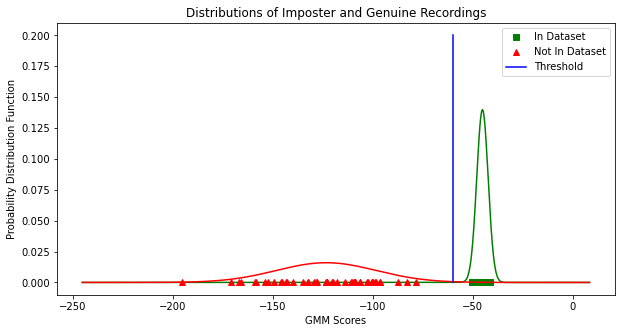

In [11]:
# Plot genuine and imposter distributions to determine a threshold

person_scores = list(genuine_scores)
person_scores.extend(imposter_scores) 

lowest_value = min(person_scores)
highest_value = max(person_scores)

x = np.arange(lowest_value-50, highest_value+50, 0.01)

genuine = norm.pdf(x, loc=np.mean(genuine_scores), scale=np.std(genuine_scores))
imposter = norm.pdf(x, loc=np.mean(imposter_scores), scale=np.std(imposter_scores))

threshold = -60

plt.figure(figsize=(10,5))
plt.plot(x, genuine, 'g')
plt.plot(genuine_scores, np.zeros(len(genuine_scores)), 'gs', lw=2, label='In Dataset')
plt.plot(x, imposter, 'r')
plt.plot(imposter_scores, np.zeros(len(imposter_scores)), 'r^', lw=2, label='Not In Dataset')
plt.plot([threshold]*20, np.linspace(0, 0.2, 20), 'b', label='Threshold')
plt.xlabel("GMM Scores")
plt.ylabel("Probability Distribution Function")
plt.legend();
plt.title('Distributions of Imposter and Genuine Recordings');

plt.show()

True Rejection Rate :83.33333333333334
False Accecptance Rate :0.0
False Rejection Rate :0.0
True Accecptance Rate :16.666666666666664


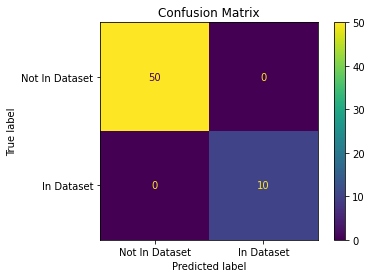

In [16]:
# Choose threshold and make confusion matrix 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

TA = 0
FA = 0
TR = 0
FR = 0

for score in genuine_scores:
    if score < threshold:
        FR = FR + 1
    else:
        TA = TA + 1

for score in imposter_scores:
    if score < threshold: 
        TR = TR + 1
    else:
        FA = FA + 1
        
Total = len(genuine_scores) + len(imposter_scores)

print("True Rejection Rate :" + str((TR/Total)*100))
print("False Accecptance Rate :" + str((FA/Total)*100))
print("False Rejection Rate :" + str((FR/Total)*100))
print("True Accecptance Rate :" + str((TA/Total)*100))

cm = np.array([[TR, FA], [FR, TA]])
labels = np.array(["Not In Dataset", "In Dataset"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.title('Confusion Matrix');
plt.show()

## Jade's Original Work

In [ ]:
# person_scores = []

# for person in people:
#     if person == people[person_num]:  # If person was trained on return the test samples from earlier
#         person_paths = test_paths
#     else:  # If person was not trained on return a random sample of 10 recordings 
#         person_paths = random.sample([x for x in paths if person in x], test_samples)
        
#     individual_scores = [] 
#     for path in person_paths:
#         sample_rate, test_data = wavfile.read(path)  # Extract data
#         mfcc_data = mfcc(test_data, sample_rate, numcep=13)  # Feature extraction
#         score = gmm.score(mfcc_data) # Calulate score
#         individual_scores.append(score)   # Get classification score for each recording
    
#     person_scores.append(individual_scores) 
        

In [ ]:

# lowest_value = min([min(x) for x in person_scores])
# highest_value = max([max(x) for x in person_scores])

# plt.figure(figsize=(20,10))
# x = np.arange(lowest_value-10, highest_value+10, 0.01)

# for idx,person in enumerate(people):
#     aProb = norm.pdf(x, loc=np.mean(person_scores[idx]), scale=np.std(person_scores[idx]))
#     plt.plot(x, aProb, ['b', 'g', 'r', 'c', 'm', 'y'][idx])
#     plt.plot(person_scores[idx], np.zeros(len(person_scores[idx])), ['b', 'g', 'r', 'c', 'm', 'y'][idx]+'s', lw=2, label=person)
#     plt.legend();
#     plt.title(f'Trained on {people[person_num]}');

# plt.show()